In [17]:
from collections import OrderedDict

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Loading

In [18]:
raw_hmda = pd.read_csv('data/hmda_lar__smith_county__all_years.csv', dtype={
    'census_tract_number': 'str'
}, na_values=[
    'Not applicable',
    'Information not provided by applicant in mail, Internet, or telephone application'
])

tract_geos = gpd.read_file('data/tl_2017_48_tract')

raw_demographics = pd.read_csv('data/ACS_16_5YR_B03002/ACS_16_5YR_B03002.csv', dtype={
    'GEO.id2': 'str'
})

raw_urban_rural = pd.read_csv('data/DEC_10_SF1_P2/DEC_10_SF1_P2.csv', dtype={
    'GEO.id2': 'str'
})

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
reporter_panels = pd.read_csv('data/processed_reporter_panels.csv')

# Enrichment

In [20]:
enriched_hmda = raw_hmda.copy(deep=True)

enriched_hmda['log_loan_amount_000s'] = np.log(enriched_hmda['loan_amount_000s'])
enriched_hmda['log_applicant_income_000s'] = np.log(enriched_hmda['applicant_income_000s'])

def race_ethnicity(row):
    if row['applicant_ethnicity_name'] == 'Hispanic or Latino':
        return 'Latino'
    elif row['applicant_ethnicity_name'] == 'Not Hispanic or Latino':
        if row['applicant_race_name_1'] == 'White':
            return 'White'
        elif row['applicant_race_name_1'] == 'Black or African American':
            return 'Black'
        elif row['applicant_race_name_1'] == 'Asian':
            return 'Asian'
        elif row['applicant_race_name_1'] == 'American Indian or Alaska Native':
            return 'Native American'
        elif row['applicant_race_name_1'] == 'Native Hawaiian or Other Pacific Islander':
            return 'Native Hawaiian'
        else:
            return np.nan
    
    return np.nan
    
def census_tract_number_string(row):
    if str(row['census_tract_number']) == 'nan':
        return None
    
    return str(row['census_tract_number']).replace('.', '').rjust(6, '0')

enriched_hmda['race_ethnicity'] = enriched_hmda.apply(race_ethnicity, axis=1)
enriched_hmda['census_tract_number_string'] = enriched_hmda.apply(census_tract_number_string, axis=1)

In [21]:
enriched_demographics = raw_demographics.copy(deep=True)

enriched_demographics['census_tract_number_string'] = enriched_demographics['GEO.id2'].str.slice(-6)

enriched_demographics['percent_white'] = enriched_demographics['HD01_VD03'] / enriched_demographics['HD01_VD01'] * 100
enriched_demographics['percent_black'] = enriched_demographics['HD01_VD04'] / enriched_demographics['HD01_VD01'] * 100
enriched_demographics['percent_latino'] = enriched_demographics['HD01_VD12'] / enriched_demographics['HD01_VD01'] * 100
enriched_demographics['percent_asian'] = enriched_demographics['HD01_VD06'] / enriched_demographics['HD01_VD01'] * 100
enriched_demographics['percent_native_american'] = enriched_demographics['HD01_VD05'] / enriched_demographics['HD01_VD01'] * 100
enriched_demographics['percent_native_hawaiian'] = enriched_demographics['HD01_VD07'] / enriched_demographics['HD01_VD01'] * 100

In [22]:
enriched_urban_rural = raw_urban_rural.copy(deep=True)

enriched_urban_rural['census_tract_number_string'] = enriched_urban_rural['GEO.id2'].str.slice(-6)

enriched_urban_rural['percent_urban'] = enriched_urban_rural['D002'] / enriched_urban_rural['D001'] * 100

# Filtering

In [23]:
filtered_hmda = enriched_hmda.copy(deep=True)

filtered_hmda = filtered_hmda[
#     (filtered_hmda['loan_type_name'] == 'Conventional') &
    (filtered_hmda['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (filtered_hmda['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (filtered_hmda['loan_purpose_name'] == 'Home purchase') &
    (filtered_hmda['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (filtered_hmda['loan_amount_000s'] < 90000) &
    (filtered_hmda['applicant_income_000s'] != 9999)
]

# Q: How many loans are approved by race and ethnicity, by year?

In [24]:
def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = filtered_hmda.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1).head(200)

race_ethnicity as_of_year action_taken_name                             \
                                           count approved denied pct_denied   
0             Asian       2007                36       30      6       16.7   
1             Asian       2008                27       25      2        7.4   
2             Asian       2009                29       25      4       13.8   
3             Asian       2010                27       22      5       18.5   
4             Asian       2011                27       19      8       29.6   
5             Asian       2012                30       24      6       20.0   
6             Asian       2013                40       34      6       15.0   
7             Asian       2014                37       30      7       18.9   
8             Asian       2015                48       42      6       12.5   
9             Asian       2016                43       39      4        9.3   
10            Asian       2017                53       49      4        7.5   
11            Black       2007               209      138     71       34.0   
12            Black       2008               132      102     30       22.7   
13            Black       2009               128       95     33       25.8   
14            Black       2010               115       79     36       31.3   
15            Black       2011                68       55     13       19.1   
16            Black       2012               107       68     39       36.4   
17            Black       2013               110       85     25       22.7   
18            Black       2014               144      118     26       18.1   
19            Black       2015               132      100     32       24.2   
20            Black       2016               175      143     32       18.3   
21            Black       2017               170      139     31       18.2   
22           Latino       2007               281      223     58       20.6   
23           Latino       2008               184      147     37       20.1   
24           Latino       2009               143      118     25       17.5   
25           Latino       2010               136      114     22       16.2   
26           Latino       2011               162      139     23       14.2   
27           Latino       2012               185      151     34       18.4   
28           Latino       2013               210      173     37       17.6   
29           Latino       2014               222      172     50       22.5   
..              ...        ...               ...      ...    ...        ...   
34  Native American       2008                 7        7      0        0.0   
35  Native American       2009                 5        5      0        0.0   
36  Native American       2010                 6        4      2       33.3   
37  Native American       2011                 5        3      2       40.0   
38  Native American       2012                42       41      1        2.4   
39  Native American       2013                25       25      0        0.0   
40  Native American       2014                11       10      1        9.1   
41  Native American       2015                 6        5      1       16.7   
42  Native American       2016                10        8      2       20.0   
43  Native American       2017                13       12      1        7.7   
44  Native Hawaiian       2007                 5        3      2       40.0   
45  Native Hawaiian       2008                 3        3      0        0.0   
46  Native Hawaiian       2011                 1        1      0        0.0   
47  Native Hawaiian       2012                 4        2      2       50.0   
48  Native Hawaiian       2013                 4        4      0        0.0   
49  Native Hawaiian       2014                 4        4      0        0.0   
50  Native Hawaiian       2015                 3        3      0        0.0   
51  Native Hawaiian       2016                 3       

# Q: How much more likely are white applicants to successfully apply for loans than applicants of color? (2010-2017)

In [25]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby('race_ethnicity', as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1)

race_ethnicity action_taken_name                             \
                               count approved denied pct_denied   
0            Asian               305      259     46       15.1   
1            Black              1021      787    234       22.9   
2           Latino              1719     1422    297       17.3   
3  Native American               118      108     10        8.5   
4  Native Hawaiian                30       27      3       10.0   
5            White             13864    12390   1474       10.6   

  applicant_income_000s loan_amount_000s  
                   mean             mean  
0                 113.8            204.5  
1                  70.3            156.0  
2                  64.9            126.0  
3                  87.3            171.7  
4                  83.6            162.9  
5                 103.5            182.1

# Q: What tracts have the highest number of loan for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

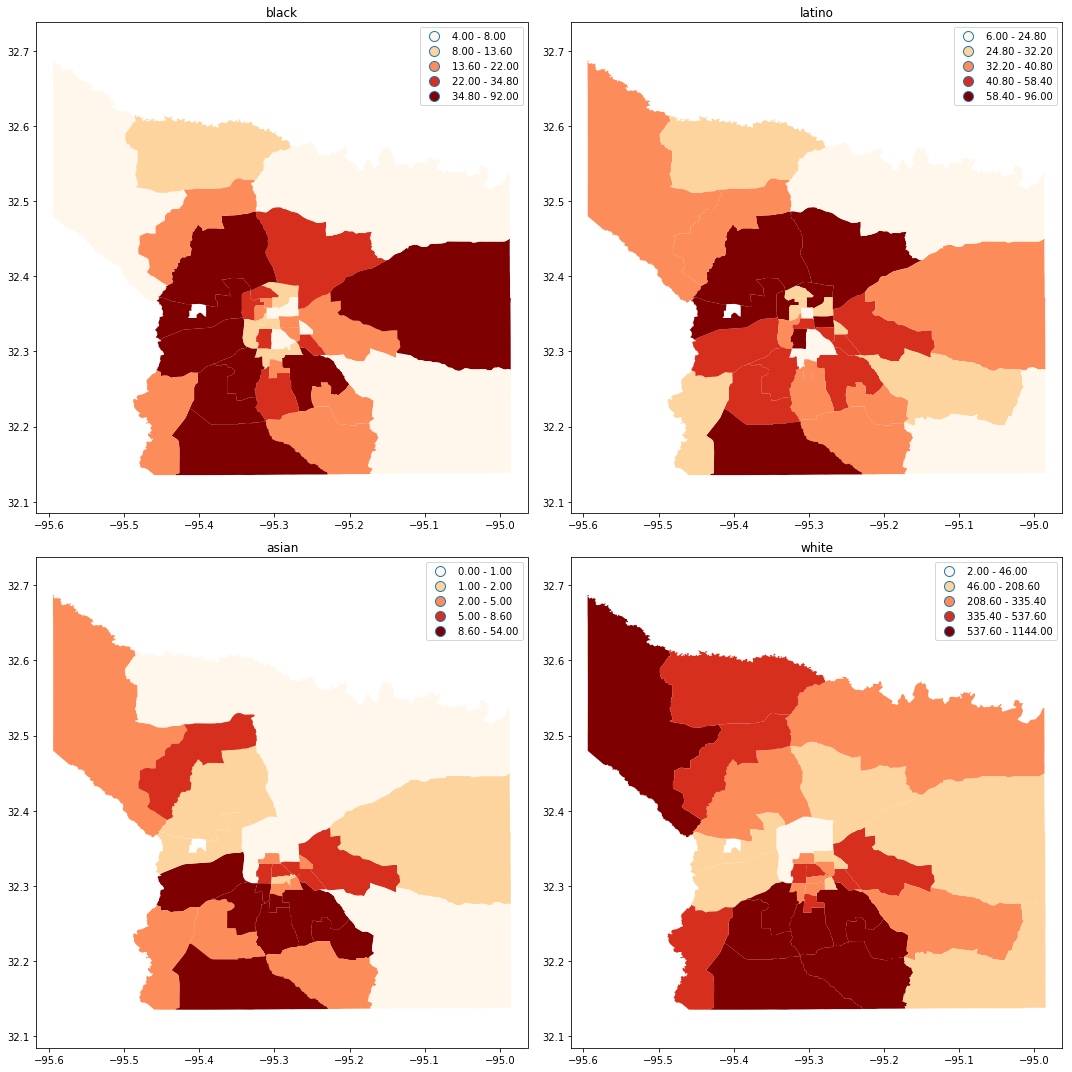

In [26]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts().get('Black', 0)

def latino(group_column):
    return group_column.value_counts().get('Latino', 0)

def asian(group_column):
    return group_column.value_counts().get('Asian', 0)

def white(group_column):
    return group_column.value_counts().get('White', 0)

def other(group_column):
    return group_column.value_counts().get('Other or N/A', 0)

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: What tracts have the highest proportion of loans for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


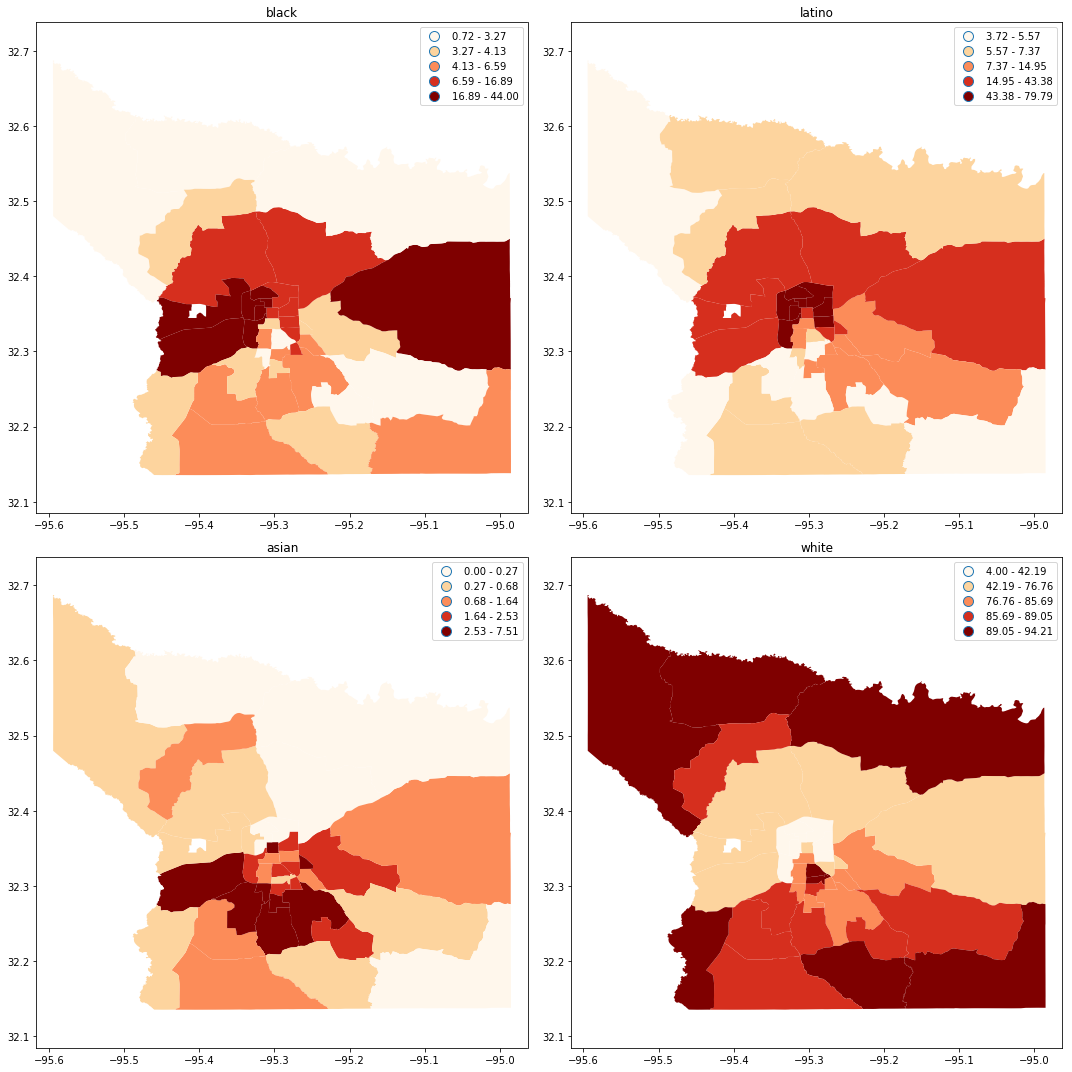

In [27]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': [black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: How are the share of black and Hispanic loans changing over time? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


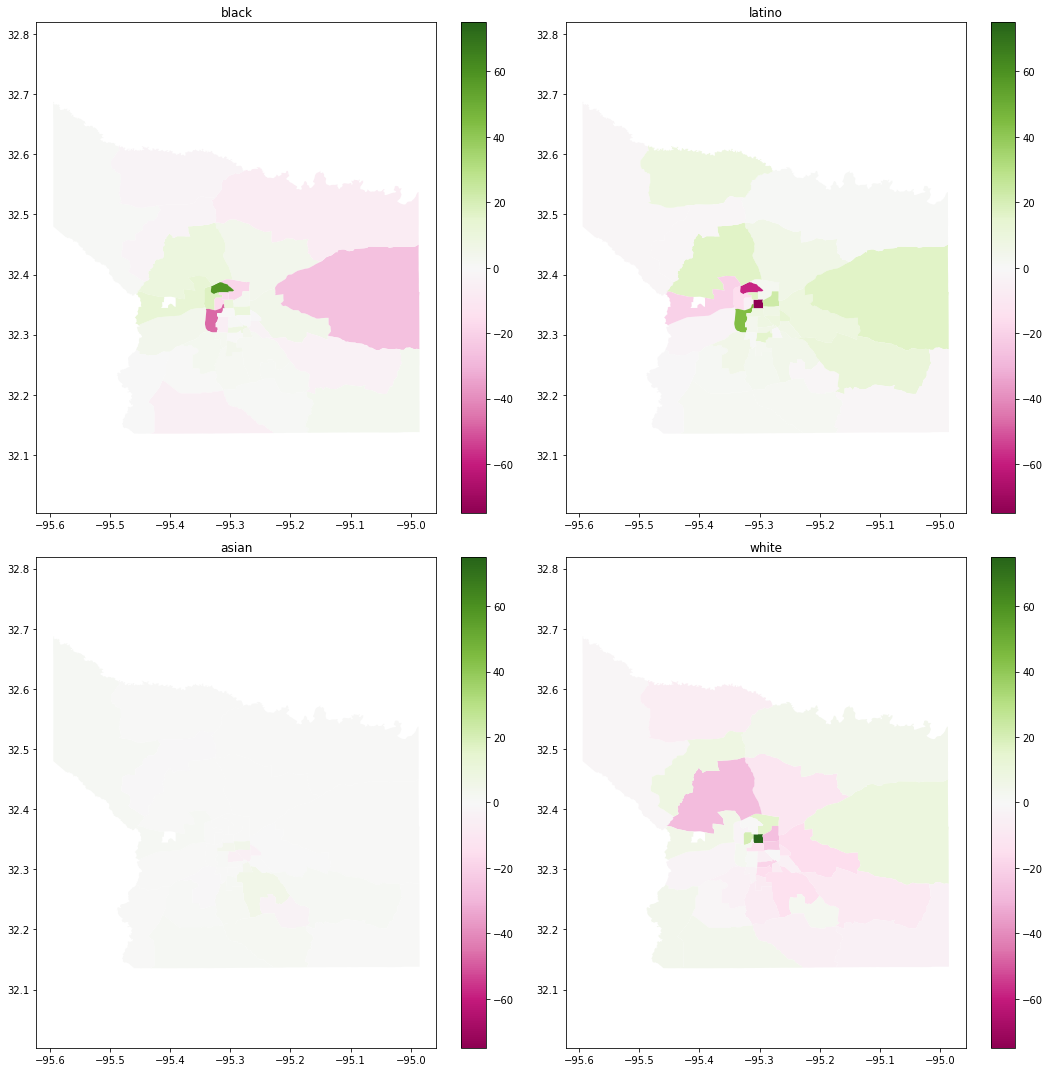

In [100]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

data = data.groupby(['census_tract_number_string', 'as_of_year'], as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

def change(group_column):
    return group_column.iat[-1] - group_column.iat[0]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    ('race_ethnicity', 'black'): change,
    ('race_ethnicity', 'latino'): change,
    ('race_ethnicity', 'asian'): change,
    ('race_ethnicity', 'white'): change
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='PiYG', legend=True, vmin=-75, vmax=75)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Are there particular banks that appear to have higher or lower rates of denial for applicants of color? (2010-2017)

In [78]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.merge(reporter_panels, left_on=['agency_abbr', 'respondent_id'], right_on=['agency_abbr', 'respondent_id'], how='left')

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['respondent_id', 'respondent_name', 'race_ethnicity'], as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied]
})

data = data[data[('action_taken_name', 'count')] >= 20]
data = data[data['race_ethnicity'].isin(['Black', 'Latino'])]
data.sort_values(by=[('action_taken_name', 'count')], ascending=False).round(1)
# data

respondent_id                 respondent_name race_ethnicity  \
                                                                   
44     0000005581                 AUSTIN BK TX NA         Latino   
172    0000018297                    SOUTHSIDE BK         Latino   
826    75-2725402                        NTFN INC         Latino   
110    0000013443                     CITIZENS NB         Latino   
825    75-2725402                        NTFN INC          Black   
917    83-0368926      AB COMMUNITY INVESTMENT CO         Latino   
171    0000018297                    SOUTHSIDE BK          Black   
500    1522600000         WR STARKEY MORTGAGE LLP         Latino   
789    73-1577221    GATEWAY MORTGAGE GROUP, LLC.         Latino   
788    73-1577221    GATEWAY MORTGAGE GROUP, LLC.          Black   
429    0002888798  PRIMELENDING A PLAINSCAPITAL C          Black   
649    32-0016270          AMCAP MORTGAGE LIMITED         Latino   
430    0002888798  PRIMELENDING A PLAINSCAPITAL C         Latino   
225    0000024077                       ALTRA FCU         Latino   
499    1522600000         WR STARKEY MORTGAGE LLP          Black   
402    0000852218            JPMORGAN CHASE BK NA         Latino   
457    0471809999          GUILD MORTGAGE COMPANY          Black   
752    68-0309242              CMG MORTGAGE, INC.         Latino   
224    0000024077                       ALTRA FCU          Black   
458    0471809999          GUILD MORTGAGE COMPANY         Latino   
929    86-0860478    PRIMARY RESIDENTIAL MORTGAGE          Black   
304    0000233031                      REGIONS BK          Black   
660    34-1194858          STONEGATE MORTGAGE LLC         Latino   
370    0000697633                      COMPASS BK         Latino   
764    7197000003             QUICKEN LOANS, INC.          Black   
930    86-0860478    PRIMARY RESIDENTIAL MORTGAGE         Latino   
765    7197000003             QUICKEN LOANS, INC.         Latino   
648    32-0016270          AMCAP MORTGAGE LIMITED          Black   
587    2317700005              PHH HOME LOANS LLC          Black   

    action_taken_name                             
                count approved denied pct_denied  
44                229      201     28       12.2  
172               157      115     42       26.8  
826               136      115     21       15.4  
110               121      114      7        5.8  
825                95       84     11       11.6  
917                89       85      4        4.5  
171                49       23     26       53.1  
500                46       43      3        6.5  
789                41       41      0        0.0  
788                40       38      2        5.0  
429                39       37      2        5.1  
649                38       36      2        5.3  
430                37       35      2        5.4  
225                36       24     12       33.3  
499                33       29      4       12.1  
402                30       13     17       56.7  
457                30       28      2        6.7  
752                27       27      0        0.0  
224                26       19      7       26.9  
458                25       24      1        4.0  
929                24       23      1        4.2  
304                24       18      6       25.0  
660                24       20      4       16.7  
370                24       18      6       25.0  
764                23       18      5       21.7  
930                23       19      4       17.4  
765                21       15      6       28.6  
648                21       20      1        4.8  
587                21       18      3       14.3

# Q: Which banks serve people of color? (2010-2017)

In [80]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.merge(reporter_panels, left_on=['agency_abbr', 'respondent_id'], right_on=['agency_abbr', 'respondent_id'], how='left')

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby(['respondent_id', 'respondent_name']).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = data[
    (data[('race_ethnicity', 'count')] >= 20) & (
        (data[('race_ethnicity', 'black')] > 15) |
        (data[('race_ethnicity', 'latino')] > 15)
    )
]
data.sort_values(by=('race_ethnicity', 'count'), ascending=False).round(1)

race_ethnicity               \
                                                      count black latino   
respondent_id respondent_name                                              
0000005581    AUSTIN BK TX NA                           805   1.9   28.4   
0000013443    CITIZENS NB                               562   1.2   21.5   
34-1194858    STONEGATE MORTGAGE LLC                    153  12.4   15.7   
0471809999    GUILD MORTGAGE COMPANY                    145  20.7   17.2   
0000697633    COMPASS BK                                110   5.5   21.8   
83-0368926    AB COMMUNITY INVESTMENT CO                109   3.7   81.7   
76-0454396    REPUBLIC STATE MORTGAGE                    99   9.1   16.2   
72-0506617    UNITED-BILT HOMES, INC.                    87  19.5   17.2   
26-0595342    MOVEMENT MORTGAGE, LLC                     76   6.6   17.1   
20-3702275    FBC MORTGAGE, LLC                          48  18.8   10.4   
7635500004    SECURITYNATIONAL MORTGAGE COMP             44  15.9    6.8   
0002590037    STATE FARM BK FSB                          32   0.0   18.8   
11-3412303    THE MONEY SOURCE                           30  26.7    6.7   
0000021074    TEXAS BK                                   26  15.4   26.9   
0000013044    BANK OF AMER NA                            25  12.0   20.0   
0000703155    HENDERSON FSB                              24  45.8    0.0   
0000005288    FIRST NB                                   22   4.5   22.7   
0000018344    HUNTINGTON ST BK                           20   0.0   25.0   

                                                          
                                             asian white  
respondent_id respondent_name                             
0000005581    AUSTIN BK TX NA                  3.0  66.6  
0000013443    CITIZENS NB                      1.2  75.4  
34-1194858    STONEGATE MORTGAGE LLC           4.6  67.3  
0471809999    GUILD MORTGAGE COMPANY           0.0  61.4  
0000697633    COMPASS BK                       1.8  69.1  
83-0368926    AB COMMUNITY INVESTMENT CO       0.0  14.7  
76-0454396    REPUBLIC STATE MORTGAGE          1.0  72.7  
72-0506617    UNITED-BILT HOMES, INC.          0.0  62.1  
26-0595342    MOVEMENT MORTGAGE, LLC           0.0  72.4  
20-3702275    FBC MORTGAGE, LLC                2.1  68.8  
7635500004    SECURITYNATIONAL MORTGAGE COMP   0.0  75.0  
0002590037    STATE FARM BK FSB                3.1  75.0  
11-3412303    THE MONEY SOURCE                 0.0  66.7  
0000021074    TEXAS BK                         0.0  57.7  
0000013044    BANK OF AMER NA                  0.0  68.0  
0000703155    HENDERSON FSB                    0.0  54.2  
0000005288    FIRST NB                         0.0  68.2  
0000018344    HUNTINGTON ST BK                10.0  65.0

# Q: Has the likelihood of being approved as person of color changed over time? (2010-2017)

In [83]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]
data = data[data['loan_type_name'].isin(['Conventional', 'FHA-insured'])]

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'action_taken_name': ['count', pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1)

# In 2016, in Tyler, of nearly 12,000 (11, 876) black households, just 139 applied for home loans. That's one out of every 85.
# By comparison, one out of every 35 white households applied. (1700 / 59,604). Whites were also nearly twice as likely to be approved.

race_ethnicity as_of_year action_taken_name             \
                                           count pct_denied   
0             Asian       2010                27       18.5   
1             Asian       2011                26       30.8   
2             Asian       2012                29       20.7   
3             Asian       2013                38       13.2   
4             Asian       2014                34       20.6   
5             Asian       2015                48       12.5   
6             Asian       2016                43        9.3   
7             Asian       2017                50        8.0   
8             Black       2010                99       33.3   
9             Black       2011                55       21.8   
10            Black       2012                88       39.8   
11            Black       2013                86       22.1   
12            Black       2014               102       20.6   
13            Black       2015               104       26.9   
14            Black       2016               139       18.7   
15            Black       2017               140       15.7   
16           Latino       2010               125       17.6   
17           Latino       2011               143       14.7   
18           Latino       2012               168       18.5   
19           Latino       2013               185       17.3   
20           Latino       2014               193       21.8   
21           Latino       2015               217       17.1   
22           Latino       2016               237       18.1   
23           Latino       2017               266       15.8   
24  Native American       2010                 6       33.3   
25  Native American       2011                 5       40.0   
26  Native American       2012                34        2.9   
27  Native American       2013                17        0.0   
28  Native American       2014                 8       12.5   
29  Native American       2015                 3       33.3   
30  Native American       2016                 7       28.6   
31  Native American       2017                10       10.0   
32  Native Hawaiian       2011                 1        0.0   
33  Native Hawaiian       2012                 4       50.0   
34  Native Hawaiian       2013                 3        0.0   
35  Native Hawaiian       2014                 4        0.0   
36  Native Hawaiian       2015                 3        0.0   
37  Native Hawaiian       2016                 2        0.0   
38  Native Hawaiian       2017                10       10.0   
39            White       2010              1270       11.3   
40            White       2011              1164       10.7   
41            White       2012              1302       13.4   
42            White       2013              1521       12.0   
43            White       2014              1482        9.1   
44            White       2015              1675        9.7   
45            White       2016              1700        9.5   
46            White       2017              1738        8.9   

   applicant_income_000s loan_amount_000s  
                    mean             mean  
0                   93.3            181.4  
1                   88.8            194.8  
2                  103.1            175.2  
3                  123.0            198.2  
4                   96.1            181.9  
5                  106.4            225.8  
6                  153.0            225.6  
7                  130.4            228.3  
8                   70.2            128.1  
9                   75.4            139.5  
10                  63.2            130.5  
11                  76.6            157.4  
12                  71.3            150.3  
13                  69.6            146.8  
14                  76.6            179.9  
15                  75.4            175.7  
16                  62.1            102.2  
17                  53.0             97.7  
18                  71.3            1

# Q: Are there census tracts with exceptionally few or many loans? (2010-2017)

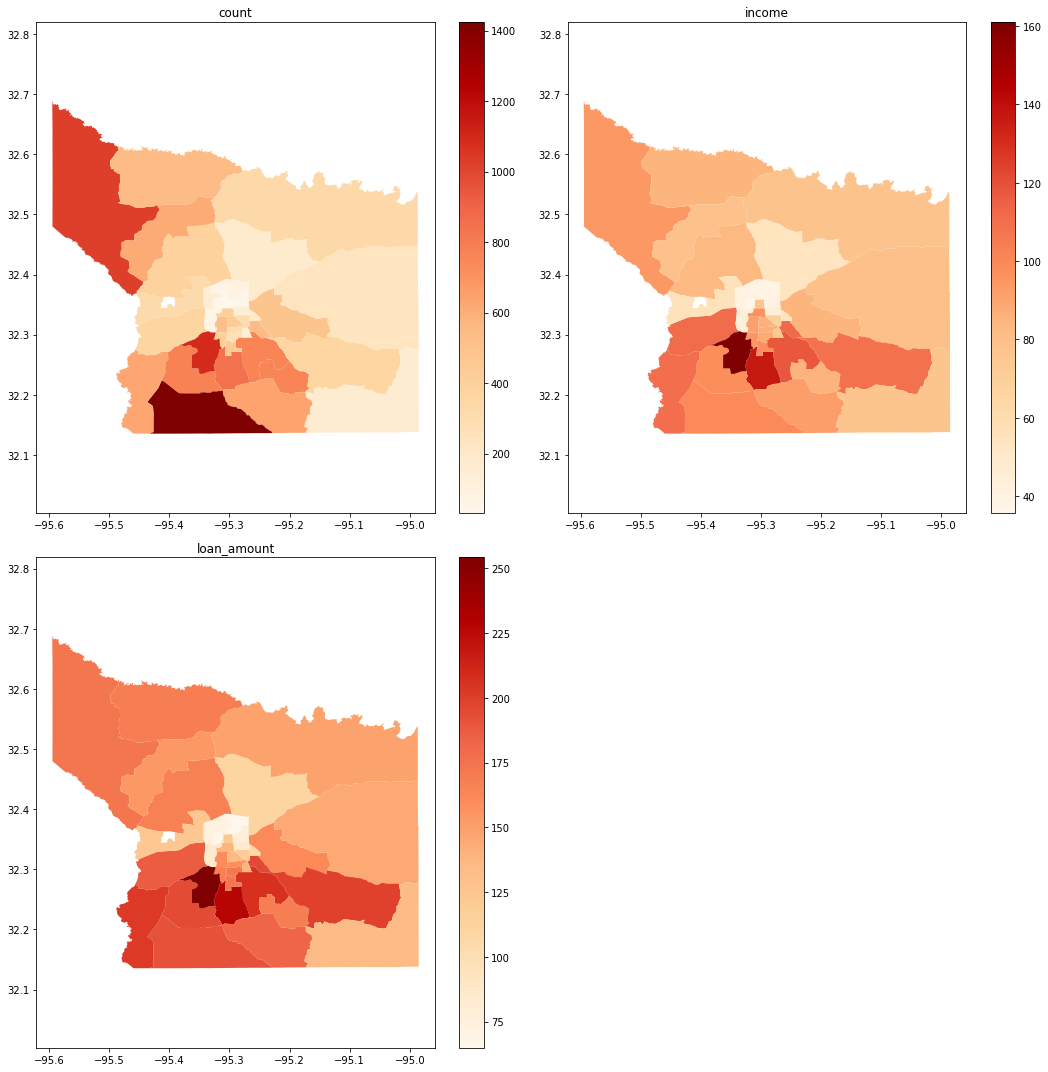

In [32]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'state_name': 'count',
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean'
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

ax = plt.subplot(2, 2, 1)
data.plot(column='state_name', ax=ax, cmap='OrRd', legend=True)
ax.set_title('count')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 2)
data.plot(column='applicant_income_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('income')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 3)
data.plot(column='loan_amount_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('loan_amount')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Is there statistical evidence of bias against applicants of color? (Reveal, 2010-2017)

In [92]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]
data = data[data['loan_type_name'] == 'Conventional']

data = data.merge(enriched_demographics, on='census_tract_number_string')
data = data.merge(enriched_urban_rural, on='census_tract_number_string')

X = pd.concat([
    # Reference variable: White
    pd.Series(data['race_ethnicity'] == 'Black', name='Black', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Latino', name='Latino', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Asian', name='Asian', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native American', name='Native American', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native Hawaiian', name='Native Hawaiian', dtype='int'),
    pd.Series(data['race_ethnicity'].isna(), name='Race N/A', dtype='int'),
    # Reference variable: Female
#     pd.Series(data['applicant_sex_name'] == 'Male', name='Male', dtype='int'),
#     pd.Series(data['applicant_sex_name'].isna(), name='Sex N/A', dtype='int'),
#     pd.Series(data['co_applicant_sex_name'].isin(['Male', 'Female']), name='Co-applicant', dtype='int'),
#     pd.Series(data['co_applicant_sex_name'].isna(), name='Co-applicant N/A', dtype='int'),
    pd.Series(np.log(data['loan_amount_000s']), name='Log of loan'),
    pd.Series(np.log(data['applicant_income_000s']), name='Log of income'),
    pd.Series(data['loan_amount_000s'] / data['applicant_income_000s'], name='Loan-to-income ratio'),
#     pd.Series(data['tract_to_msamd_income'], name='Tract-MSA median income ratio'),
    pd.Series(data['percent_black'], name='Percent black in tract'),
    pd.Series(data['percent_latino'], name='Percent Latino in tract'),
    pd.Series(data['percent_asian'], name='Percent Asian in tract'),
#     pd.Series(data['percent_native_american'], name='Percent Native American in tract'),
#     pd.Series(data['percent_native_hawaiian'], name='Percent Native Hawaiian in tract'),
#     pd.Series(data['percent_black'] > 50, name='Majority black tract', dtype='int'),
#     pd.Series(data['percent_latino'] > 50, name='Majority Latino tract', dtype='int'),
#     pd.Series(data['percent_white'] > 50, name='Majority white tract', dtype='int'),
    # Reference variable: FDIC
    pd.Series(data['agency_abbr'] == 'OCC', name='OCC', dtype='int'),
#     pd.Series(data['agency_abbr'] == 'FRS', name='FRS', dtype='int'),
#     pd.Series(data['agency_abbr'] == 'NCUA', name='NCUA', dtype='int'),
#     pd.Series(data['agency_abbr'] == 'HUD', name='HUD', dtype='int'),
    pd.Series(data['agency_abbr'] == 'CFPB', name='CFPB', dtype='int'),
    pd.Series(data['agency_abbr'] == 'OTS', name='OTS', dtype='int'),
#     pd.Series(data['as_of_year'], name='Year'),
    # Reference: all banks with fewer than 500 loans
#     pd.Series(data['respondent_id'] == '75-2725402', name='NTFN', dtype='int'),
    pd.Series(data['respondent_id'] == '0000018297', name='Southside Bank', dtype='int'),
#     pd.Series(data['respondent_id'] == '0000005581', name='Austin Bank', dtype='int'),
#     pd.Series(data['respondent_id'] == '1522600000', name='WR Starkey Mortgage', dtype='int'),
#     pd.Series(data['respondent_id'] == '0000013443', name='Citizen\'s National Bank', dtype='int'),
#     pd.Series(data['respondent_id'] == '0000017842', name='Texas Bank', dtype='int'),
#     pd.Series(data['respondent_id'] == '0002888798', name='PlainsCapital', dtype='int'),
#     pd.Series(data['respondent_id'] == '0000024077', name='Altra Federal Credit Union', dtype='int'),
#     pd.Series(data['respondent_id'] == '7197000003', name='Quicken Loans', dtype='int'),
    pd.Series(data['respondent_id'] == '68-0309242', name='CMG Mortgage', dtype='int'),
#     pd.Series(data['respondent_id'] == '86-0860478', name='Primary Residential Mortgage', dtype='int'),
#     pd.Series(data['respondent_id'] == '73-1577221', name='Gateway Mortgage Group', dtype='int'),
#     pd.Series(data['respondent_id'] == '0000451965', name='Wells Fargo', dtype='int'),
    pd.Series(data['respondent_id'] == '0000619877', name='USAA', dtype='int'),
#     pd.get_dummies(data['census_tract_number_string']),
    pd.Series(data['percent_urban'], name='Percent urban')
], axis=1)

y = pd.Series(data['action_taken_name'] == 'Application denied by financial institution', name='Denied', dtype='int')

logit = sm.Logit(y, X, missing='drop')
result = logit.fit()

result.summary()

# np.exp(result.params)

# Over the life of the loan FHA tends to be more expensive because they have higher interest rates and PMI
# Tend to go to folks with lower credit score or higher debt-to-income ratio
# Go to "riskier" borrowers

# What is Southside's definition of "poor credit history"
# Is that why they deny loans that otherwise look like good bets

# Look at banks v. credit unions v. independent mortgage banker instead of regulatory agency
# Reporter panel allows you to determine what kind of lender they are
# Banks are subject to Community Reinvestment Act (CRA)

# They didn't model specific banks

# ADD PERCENT IN POVERTY

# We tried dozens of different models. In virtually all of them blacks were between 2 and 3 times more likely to be denied.

Optimization terminated successfully.
         Current function value: 0.330470
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Denied   No. Observations:                10256
Model:                          Logit   Df Residuals:                    10237
Method:                           MLE   Df Model:                           18
Date:                Thu, 02 Aug 2018   Pseudo R-squ.:                  0.1028
Time:                        20:05:26   Log-Likelihood:                -3389.3
converged:                       True   LL-Null:                       -3777.7
                                        LLR p-value:                2.855e-153
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Black                       0.8749      0.142      6.143      0.000       0.596       1.154
Latino                      0.1072      0.113      0.947      0.344      -0.115       0.329
Asian                       0.6720      0.201      3.348      0.001       0.279       1.065
Native American             0.6053      0.435      1.391      0.164      -0.248       1.458
Native Hawaiian            -0.2120      1.040     -0.204      0.838      -2.251       1.827
Race N/A                    0.5990      0.127      4.710      0.000       0.350       0.848
Log of loan                -0.7256      0.106     -6.831      0.000      -0.934      -0.517
Log of income               0.1623      0.101      1.613      0.107      -0.035       0.360
Loan-to-income ratio        0.4424      0.051      8.741      0.000       0.343       0.542
Percent black in tract      0.0105      0.003      3.502      0.000       0.005       0.016
Percent Latino in tract     0.0108      0.003      3.489      0.000       0.005       0.017
Percent Asian in tract     -0.0730      0.020     -3.682      0.000      -0.112      -0.034
OCC                         0.1523      0.086      1.767      0.077      -0.017       0.321
CFPB                        0.6660      0.091      7.327      0.000       0.488       0.844
OTS                         0.6695      0.342      1.959      0.050      -0.000       1.339
Southside Bank              0.8439      0.103      8.181      0.000       0.642       1.046
CMG Mortgage               -5.7948      1.485     -3.902      0.000      -8.705      -2.884
USAA                        0.5040      0.217      2.323      0.020       0.079       0.929
Percent urban              -0.0084      0.001     -7.293      0.000      -0.011      -0.006
===========================================================================================
"""

# Q: Are there banks which are obviously redlining?

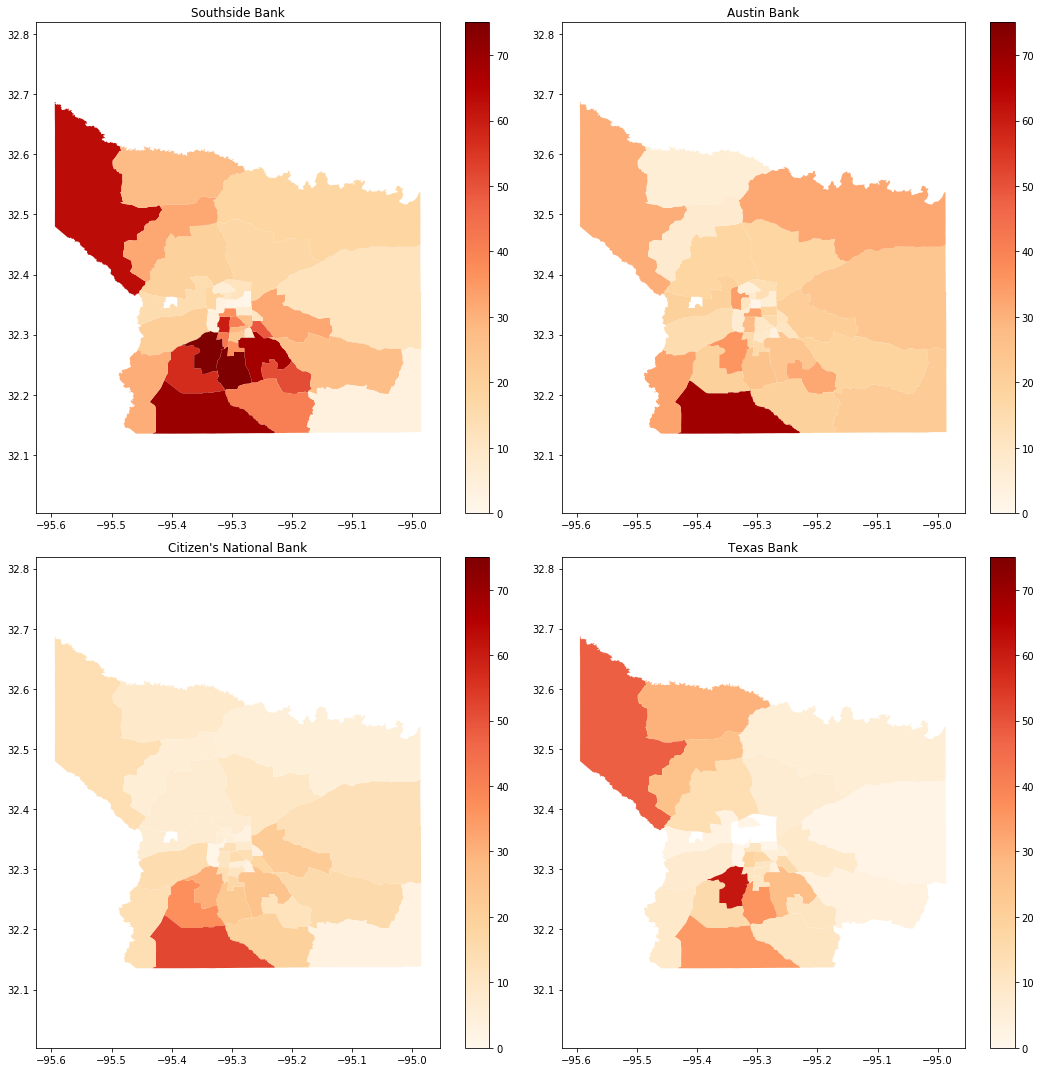

In [34]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.groupby(['respondent_id', 'census_tract_number_string'], as_index=False).agg({
    'state_name': 'count'
})

data = tract_geos.merge(data, how='right', left_on='TRACTCE', right_on='census_tract_number_string')

banks = data.groupby('respondent_id')

plt.figure(figsize=(15, 15))

ax = plt.subplot(2, 2, 1)
banks.get_group('0000018297').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Southside Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 2)
banks.get_group('0000005581').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Austin Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 3)
banks.get_group('0000013443').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Citizen\'s National Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 4)
banks.get_group('0000017842').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Texas Bank')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Are black Tylerites mortgaging their houses for cash?

In [35]:
data = enriched_hmda[enriched_hmda['as_of_year'] >= 2010]

data = data[
    (data['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (data['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (data['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (data['loan_amount_000s'] < 90000) &
    (data['applicant_income_000s'] != 9999)
]

def purchase(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Home purchase', 0)

def refinance(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Refinancing', 0)

def home_improvement(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Home improvement', 0)

data = data.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'loan_purpose_name': ['count', purchase, refinance, home_improvement]
})

data.round(1)

race_ethnicity as_of_year loan_purpose_name                     \
                                           count purchase refinance   
0             Asian       2010                68       27        39   
1             Asian       2011                72       27        42   
2             Asian       2012                73       30        38   
3             Asian       2013                71       40        29   
4             Asian       2014                55       37        15   
5             Asian       2015                76       48        25   
6             Asian       2016                59       43        16   
7             Asian       2017                71       53        14   
8             Black       2010               292      115       126   
9             Black       2011               223       68       116   
10            Black       2012               308      107       147   
11            Black       2013               414      110       200   
12            Black       2014               354      144       152   
13            Black       2015               376      132       181   
14            Black       2016               462      175       210   
15            Black       2017               418      170       151   
16           Latino       2010               339      136       134   
17           Latino       2011               323      162       120   
18           Latino       2012               411      185       166   
19           Latino       2013               439      210       164   
20           Latino       2014               412      222       136   
21           Latino       2015               462      248       163   
22           Latino       2016               465      265       145   
23           Latino       2017               472      291       128   
24  Native American       2010                19        6        13   
25  Native American       2011                24        5        13   
26  Native American       2012                58       42        13   
27  Native American       2013                39       25        12   
28  Native American       2014                21       11         8   
29  Native American       2015                16        6         9   
30  Native American       2016                24       10        13   
31  Native American       2017                22       13         8   
32  Native Hawaiian       2010                 8        0         7   
33  Native Hawaiian       2011                 4        1         0   
34  Native Hawaiian       2012                 7        4         2   
35  Native Hawaiian       2013                 9        4         4   
36  Native Hawaiian       2014                 8        4         2   
37  Native Hawaiian       2015                 6        3         3   
38  Native Hawaiian       2016                 7        3         4   
39  Native Hawaiian       2017                13       11         2   
40            White       2010              3721     1465      1946   
41            White       2011              3510     1370      1849   
42            White       2012              4053     1543      2221   
43            White       2013              4012     1810      1851   
44            White       2014              3052     1752      1022   
45            White       2015              3438     1945      1213   
46            White       2016              3740     1977      1427   
47            White       2017              3178     2002       870   

                     
   home_improvement  
0                 2  
1                 3  
2                 5  
3                 2  
4                 3  
5                 3  
6                 0  
7                 4  
8                51  
9                39  
10               54  
11              104  
12               58  
13               63  
14               77  
15               97  
16               69  
17               41  
18            